In [2]:
import r3.adapters as adapters
import r3.schema as schema

X_columns = [
    schema.IVTReactionSchema.NTP_M.value,
    schema.IVTReactionSchema.T7RNAP_u_uL.value,
    schema.IVTReactionSchema.DNA_ug_mL.value,
    schema.IVTReactionSchema.Mg2_M.value,
    schema.IVTReactionSchema.TIME_min.value,
]
y_columns = [schema.IVTReactionSchema.dsRNA_percent.value]

experimental_conditions, responses = adapters.DataPipelineAdapter("dsrna_lhs").get(
    X_columns=X_columns,
    y_columns=y_columns,
)

experimental_conditions

📊 Extracted DataFrame with columns ['NTPs [M]', 'T7RNAP [units/uL]', 'DNA [µg/mL]', 'Mg2+ [M]', 'Reaction Time [min]'] and ['dsRNA [%]']
X shape: (80, 5), y shape: (80, 1)
X head:
   NTPs [M]  T7RNAP [units/uL]  DNA [µg/mL]  Mg2+ [M]  Reaction Time [min]
0  0.002237         109.285882    49.217245  0.013340            15.975448
1  0.011370         102.000948    92.963862  0.045625           205.895482
2  0.013120         301.864929    91.286401  0.034906            89.767563
3  0.012105         277.820595    61.743404  0.026270            44.601100
4  0.012105         277.820595    61.743404  0.026270            44.601100
y head:
   dsRNA [%]
0   2.130682
1   0.411220
2   0.035209
3   0.422909
4   0.150595


,NTPs [M],T7RNAP [units/uL],DNA [µg/mL],Mg2+ [M],Reaction Time [min]
0,0.002237,109.285882,49.217245,0.013340,15.975448
1,0.011370,102.000948,92.963862,0.045625,205.895482
2,0.013120,301.864929,91.286401,0.034906,89.767563
3,0.012105,277.820595,61.743404,0.026270,44.601100
4,0.012105,277.820595,61.743404,0.026270,44.601100
...,...,...,...,...,...
75,0.014942,359.010522,54.952946,0.054598,143.752553
76,0.002423,148.507894,81.381476,0.009032,188.421396
77,0.008220,337.662327,74.517838,0.028639,73.872966
78,0.011866,287.674023,69.082018,0.067321,92.660776


In [3]:
# Remove samples with dsRNA [%] > 4% from experimental_conditions and responses in-place
# high_dsRNA_mask = responses[y_columns[0]] > 4.0
# experimental_conditions.drop(index=responses[high_dsRNA_mask].index, inplace=True)
# responses.drop(index=responses[high_dsRNA_mask].index, inplace=True)

## Correlation & Distribution


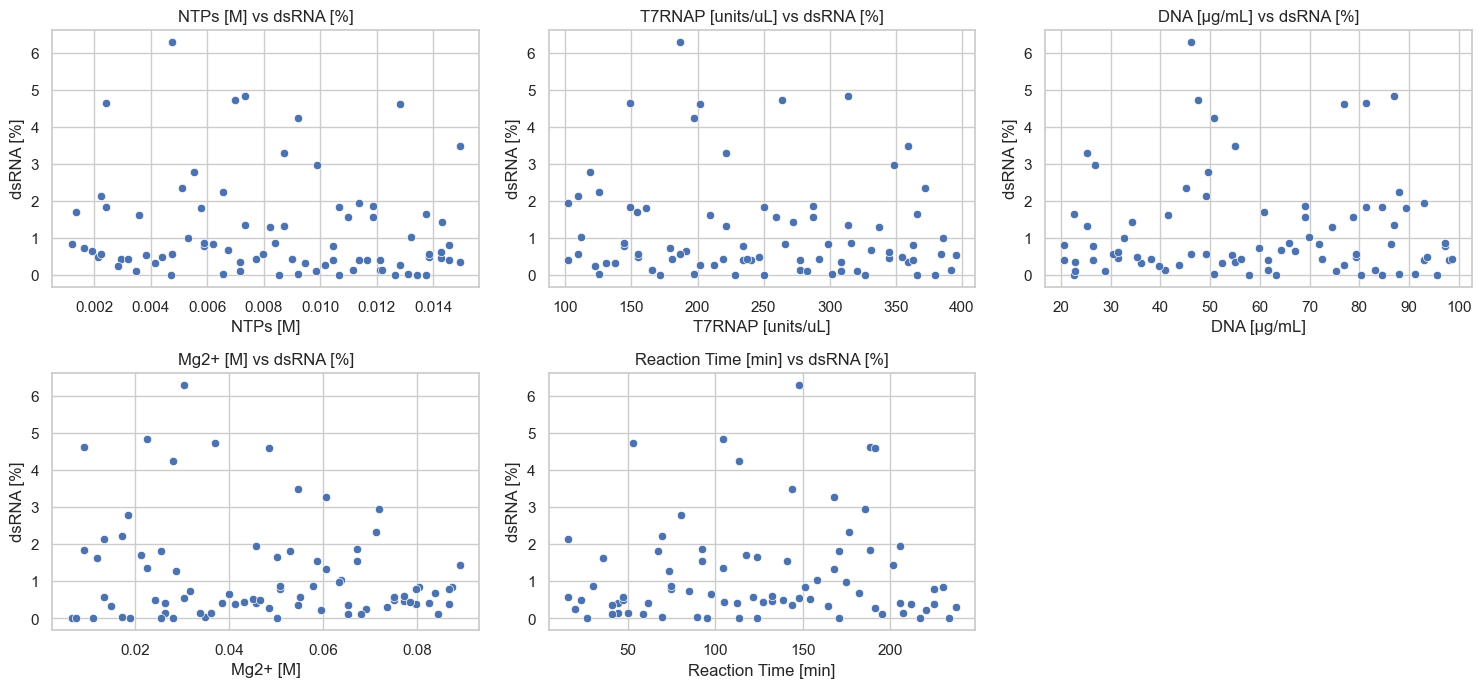

In [4]:
# plot the experimental conditions against the response in a grid
import matplotlib.pyplot as plt
import seaborn as sns

experimental_data = experimental_conditions.copy()
experimental_data[y_columns[0]] = responses
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
for i, col in enumerate(X_columns):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=experimental_data, x=col, y=y_columns[0])
    plt.title(f"{col} vs {y_columns[0]}")
    plt.xlabel(col)
    plt.ylabel(y_columns[0])
plt.tight_layout()

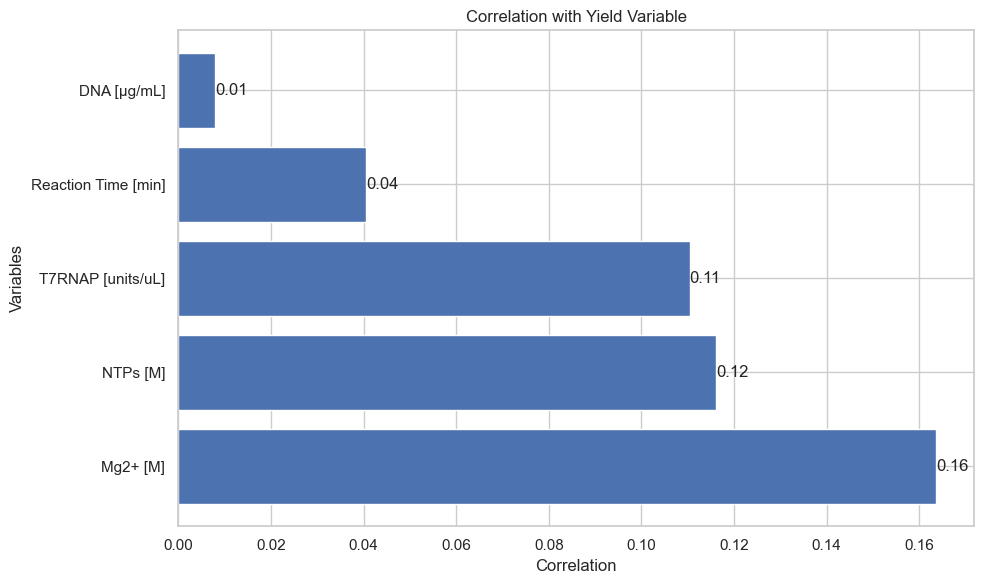

In [5]:
# Calculate the correlation coefficients with the yield variable
corr_matrix = experimental_data.corr()
correlations = corr_matrix[y_columns[0]].drop(y_columns[0])

# Sort the correlations in descending order
correlations = correlations.abs().sort_values(ascending=False)

# Create a horizontal bar chart of the correlations
plt.figure(figsize=(10, 6))
plt.barh(correlations.index, correlations.values)
plt.xlabel("Correlation")
plt.ylabel("Variables")
plt.title("Correlation with Yield Variable")
plt.tight_layout()
# add correlation values to the bars
for index, value in enumerate(correlations):
    plt.text(value, index, f"{value:.2f}", va="center")

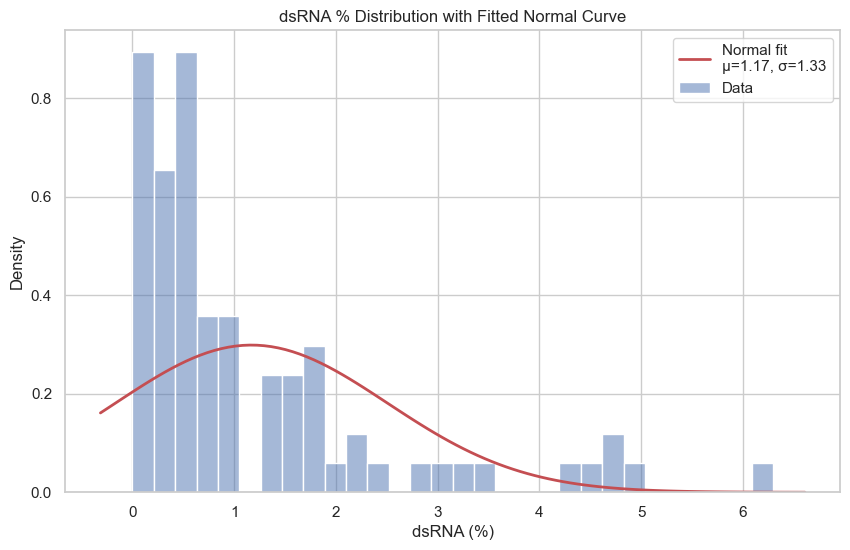

In [6]:
from scipy import stats
import numpy as np

# Fit a normal distribution
mu, std = stats.norm.fit(responses.values)

# Plot histogram and fitted PDF
plt.figure(figsize=(10, 6))
sns.histplot(
    responses.values, bins=30, kde=False, stat="density", color="skyblue", label="Data"
)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r", linewidth=2, label=f"Normal fit\nμ={mu:.2f}, σ={std:.2f}")
plt.title("dsRNA % Distribution with Fitted Normal Curve")
plt.xlabel("dsRNA (%)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Preliminary Model Fit


Root Mean squared error on training set: 1.3233723590087247
R-squared score on training: 0.017313048985064805


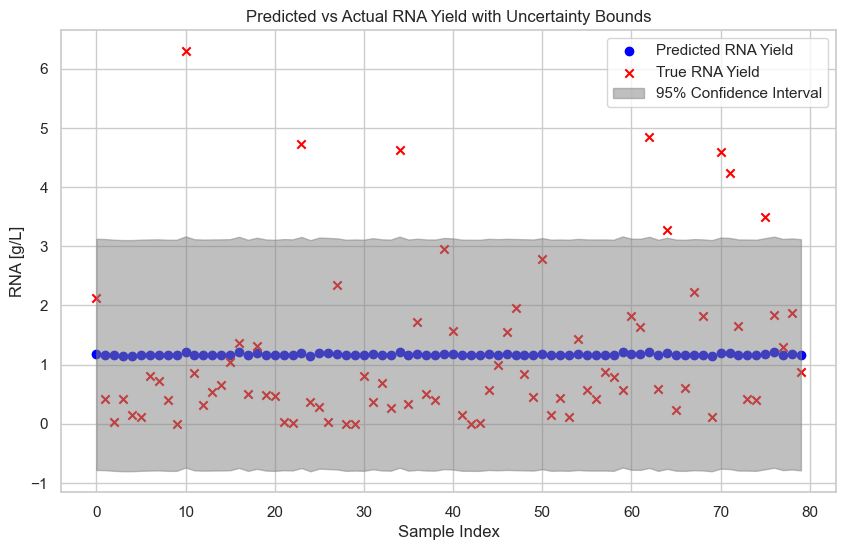

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

X_train, y_train = experimental_conditions[X_columns], responses[y_columns[0]]

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

df = pd.DataFrame(X_train_scaled, columns=X_columns)
df[y_columns[0]] = y_train_scaled

matern_gp_model = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2))
    * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5)
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-2, 1e2)),
    n_restarts_optimizer=100,
    random_state=42,
)
matern_gp_model.fit(X_train_scaled, y_train_scaled)

# Training set predictions
pre_scaled_pred = matern_gp_model.predict(X_train_scaled)
predictions = scaler_y.inverse_transform(pre_scaled_pred.reshape(-1, 1)).flatten()
print(
    "Root Mean squared error on training set:",
    np.sqrt(mean_squared_error(y_train, predictions)),
)
print(
    "R-squared score on training:",
    matern_gp_model.score(X_train_scaled, y_train_scaled),
)

x_axis = np.arange(len(X_train))
plt.figure(figsize=(10, 6))
plt.scatter(
    x_axis,
    predictions,
    label="Predicted RNA Yield",
    color="blue",
    marker="o",
)
plt.scatter(x_axis, y_train, label="True RNA Yield", color="red", marker="x")
plt.fill_between(
    x_axis,
    predictions - 1.96 * np.sqrt(matern_gp_model.kernel_.k2.noise_level),
    predictions + 1.96 * np.sqrt(matern_gp_model.kernel_.k2.noise_level),
    color="gray",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel(schema.IVTReactionSchema.RNA_g_L.value)
plt.title("Predicted vs Actual RNA Yield with Uncertainty Bounds")
plt.legend()

# Dimensionality Reduction

Using PCA and t-SNE to reduce the dimensionality of the dataset and visualize
patterns or clusters among samples.


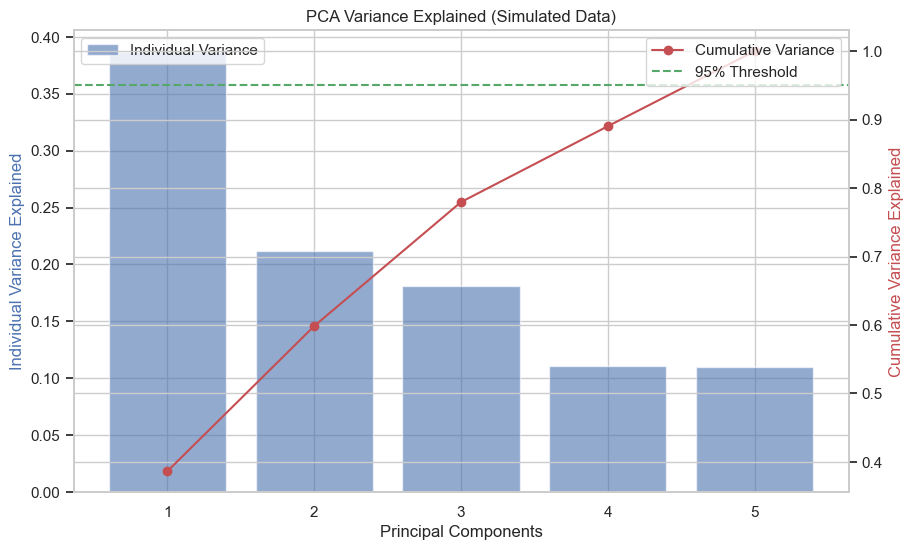

In [8]:
from sklearn.decomposition import PCA

# Apply PCA to the experimental_data (excluding the response column)
features = [col for col in experimental_data.columns if col != y_columns[0]]
pca = PCA(n_components=len(features))

# normalize the experimental data before PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(experimental_data[features])

pca.fit(X_scaled)

# Get loadings (components)
loadings = pca.components_.T

# Extract explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plotting
components = np.arange(1, len(explained_variance) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for individual variance
ax1.bar(
    components,
    explained_variance,
    alpha=0.6,
    label="Individual Variance",
    color="b",
)
# Line plot for cumulative variance
ax2 = ax1.twinx()
ax2.plot(
    components,
    cumulative_variance,
    marker="o",
    color="r",
    label="Cumulative Variance",
)
# Add 95% dotted line
ax2.axhline(y=0.95, color="g", linestyle="--", label="95% Threshold")

# Labels and title
ax1.set_xlabel("Principal Components")
ax1.set_ylabel("Individual Variance Explained", color="b")
ax2.set_ylabel("Cumulative Variance Explained", color="r")
ax1.set_title("PCA Variance Explained (Simulated Data)")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

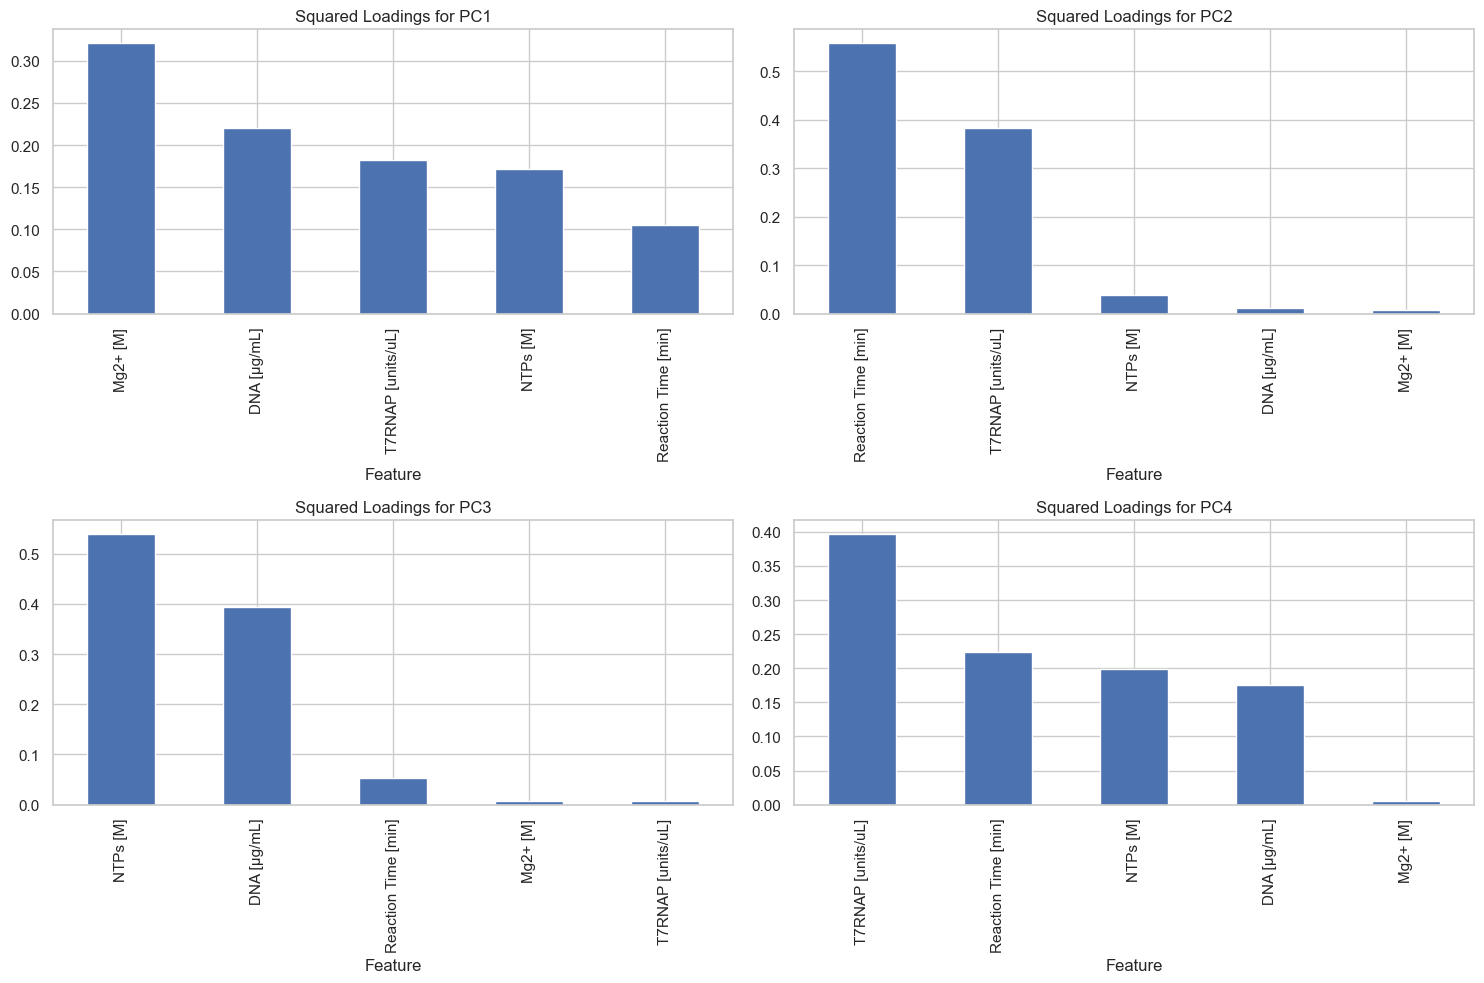

In [9]:
# Square the loadings for the first principal component
squared_loadings_pc1 = loadings[:, 0] ** 2
squared_loadings_pc2 = loadings[:, 1] ** 2
squared_loadings_pc3 = loadings[:, 2] ** 2
squared_loadings_pc4 = loadings[:, 3] ** 2

# show the pandas dataframe of the squared loadings with the feature names
squared_loadings_df = pd.DataFrame(
    {
        "Feature": features,
        "Squared Loading PC1": squared_loadings_pc1,
        "Squared Loading PC2": squared_loadings_pc2,
        "Squared Loading PC3": squared_loadings_pc3,
        "Squared Loading PC4": squared_loadings_pc4,
    }
)

# plot bar plots of the squared loadings for each principal component
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
squared_loadings_df.sort_values("Squared Loading PC1", ascending=False).plot.bar(
    x="Feature",
    y="Squared Loading PC1",
    ax=axes[0, 0],
    legend=False,
    title="Squared Loadings for PC1",
)
squared_loadings_df.sort_values("Squared Loading PC2", ascending=False).plot.bar(
    x="Feature",
    y="Squared Loading PC2",
    ax=axes[0, 1],
    legend=False,
    title="Squared Loadings for PC2",
)
squared_loadings_df.sort_values("Squared Loading PC3", ascending=False).plot.bar(
    x="Feature",
    y="Squared Loading PC3",
    ax=axes[1, 0],
    legend=False,
    title="Squared Loadings for PC3",
)
squared_loadings_df.sort_values("Squared Loading PC4", ascending=False).plot.bar(
    x="Feature",
    y="Squared Loading PC4",
    ax=axes[1, 1],
    legend=False,
    title="Squared Loadings for PC4",
)
plt.tight_layout()
plt.show()

Best number of components: 1
R-squared: 0.036518737705489746
Root Mean Squared Error: 1.3103765161255745


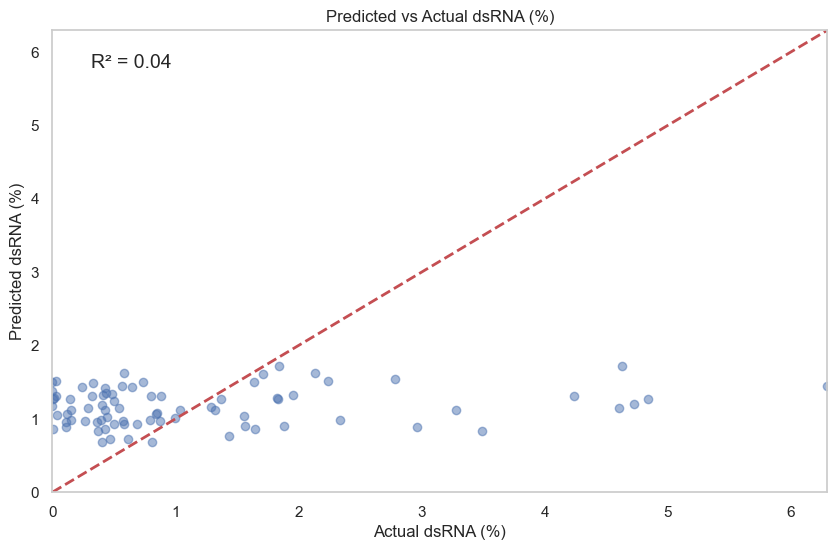

In [10]:
# normalize the experimental data before PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(experimental_data[features])
y_train_scaled = scaler.fit_transform(responses.values.reshape(-1, 1)).flatten()

# Create a PLS model
pls = PLSRegression()

# Use GridSearchCV to find the best number of components using KFold cross-validation
param_grid = {"n_components": list(range(1, 10))}
kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(pls, param_grid, cv=kf, scoring="neg_mean_squared_error")
grid_search.fit(X_train_scaled, y_train_scaled)

# Best number of components
best_n_components = grid_search.best_params_["n_components"]
print(f"Best number of components: {best_n_components}")

# Fit the PLS model with the best number of components
pls_best = PLSRegression(n_components=best_n_components)
pls_best.fit(X_train_scaled, y_train_scaled)

# Predict on the test set
Y_pred_scaled = pls_best.predict(X_train_scaled)

# Inverse transform the predicted values
predictions = scaler_y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()

# Calculate mean squared error and root mean squared error for the predictions
rmse = np.sqrt(mean_squared_error(y_train, predictions))
# Calculate R-squared for the predictions
r2 = r2_score(y_train, predictions)

# Print results
print(f"R-squared: {r2}")
print(f"Root Mean Squared Error: {rmse}")

# Plot the predicted vs actual RNA yield
plt.figure(figsize=(10, 6))
plt.scatter(y_train, predictions, alpha=0.5)
plt.text(
    0.05,
    0.95,
    f"R² = {r2:.2f}",
    transform=plt.gca().transAxes,
    fontsize=14,
    verticalalignment="top",
)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2)
plt.title("Predicted vs Actual dsRNA (%)")
plt.xlabel("Actual dsRNA (%)")
plt.ylabel("Predicted dsRNA (%)")
plt.xlim(y_train.min(), y_train.max())
plt.ylim(y_train.min(), y_train.max())
plt.grid()

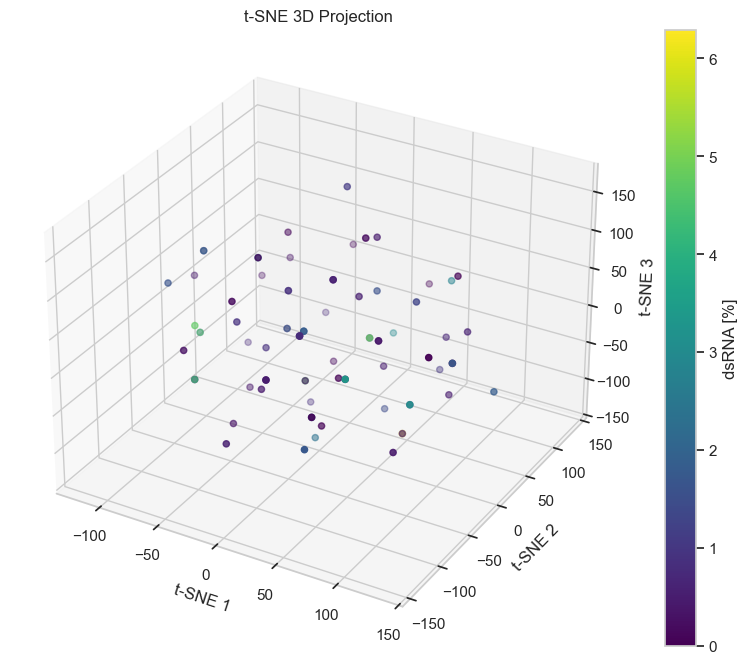

In [11]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Apply t-SNE with 3 components
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(
    X_tsne_3d[:, 0],
    X_tsne_3d[:, 1],
    X_tsne_3d[:, 2],
    c=experimental_data[y_columns[0]],
    cmap="viridis",
)
ax.set_title("t-SNE 3D Projection")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
fig.colorbar(sc, label=y_columns[0])
plt.show()

# Clustering Analysis

Doing cluster analysis we could identify groups of samples with similar outcomes and
analyse their characteristics.


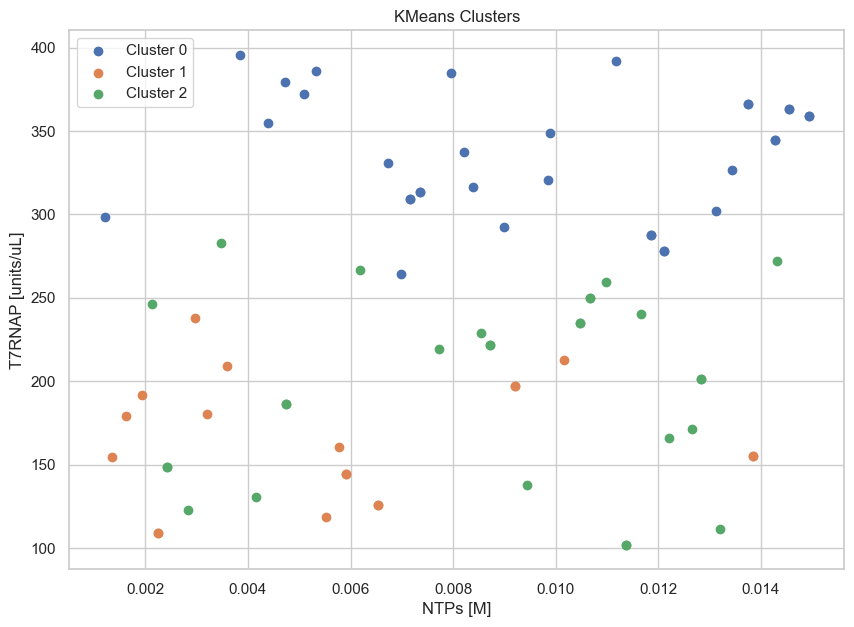

In [12]:
from sklearn.cluster import KMeans

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
experimental_data["Cluster"] = kmeans.fit_predict(experimental_data[features])

# Plot clusters in feature space (e.g., using first two features)
plt.figure(figsize=(10, 7))
for cluster in range(n_clusters):
    subset = experimental_data[experimental_data["Cluster"] == cluster]
    plt.scatter(subset[features[0]], subset[features[1]], label=f"Cluster {cluster}")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title("KMeans Clusters")
plt.legend()
plt.show()

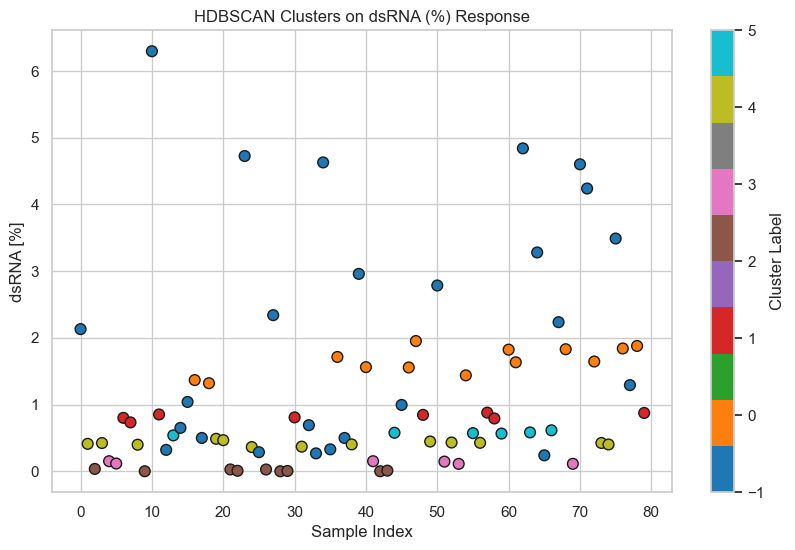

In [13]:
import hdbscan

# Fit HDBSCAN directly on the response values (reshaped to 2D)
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
hdbscan_labels_response = clusterer.fit_predict(y_train.values.reshape(-1, 1))

# Plot clusters in response space colored by cluster label
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    np.arange(len(y_train)),
    y_train,
    c=hdbscan_labels_response,
    cmap="tab10",
    s=60,
    edgecolor="k",
)
plt.xlabel("Sample Index")
plt.ylabel(y_columns[0])
plt.title("HDBSCAN Clusters on dsRNA (%) Response")
plt.colorbar(scatter, label="Cluster Label")
plt.show()

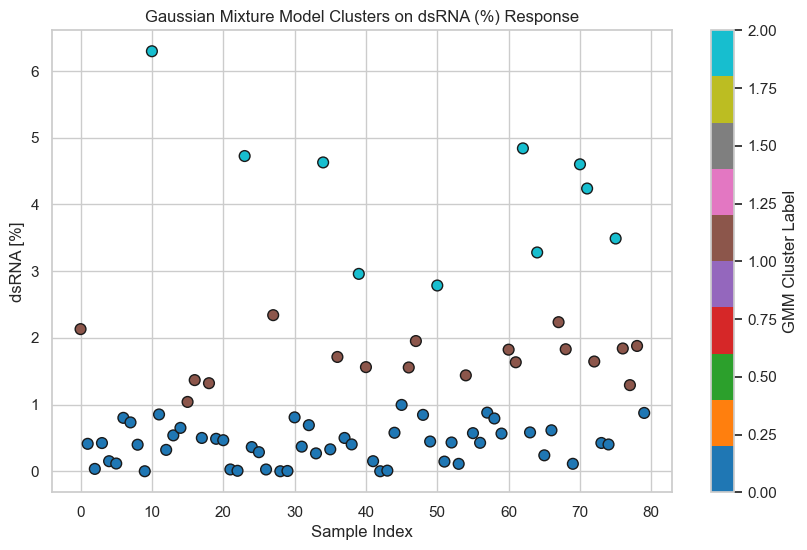

   Cluster_0_Prob  Cluster_1_Prob  Cluster_2_Prob
0    1.576129e-08        0.946134        0.053866
1    9.924146e-01        0.007488        0.000098
2    9.983383e-01        0.001599        0.000063
3    9.918883e-01        0.008010        0.000102
4    9.976851e-01        0.002255        0.000060


In [14]:
from sklearn.mixture import GaussianMixture

# Fit Gaussian Mixture Model on dsRNA percentage response
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(y_train.values.reshape(-1, 1))

# Plot clusters in response space colored by GMM cluster label
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    np.arange(len(y_train)),
    y_train,
    c=gmm_labels,
    cmap="tab10",
    s=60,
    edgecolor="k",
)
plt.xlabel("Sample Index")
plt.ylabel(y_columns[0])
plt.title("Gaussian Mixture Model Clusters on dsRNA (%) Response")
plt.colorbar(scatter, label="GMM Cluster Label")
plt.show()

# show the probability score of each sample belonging to each cluster
gmm_probs = gmm.predict_proba(y_train.values.reshape(-1, 1))
gmm_probs_df = pd.DataFrame(
    gmm_probs, columns=[f"Cluster_{i}_Prob" for i in range(gmm.n_components)]
)
print(gmm_probs_df.head())

Text(0.5, 1.0, 'Stratified Conditions with GMM Clusters on dsRNA (%) Response')

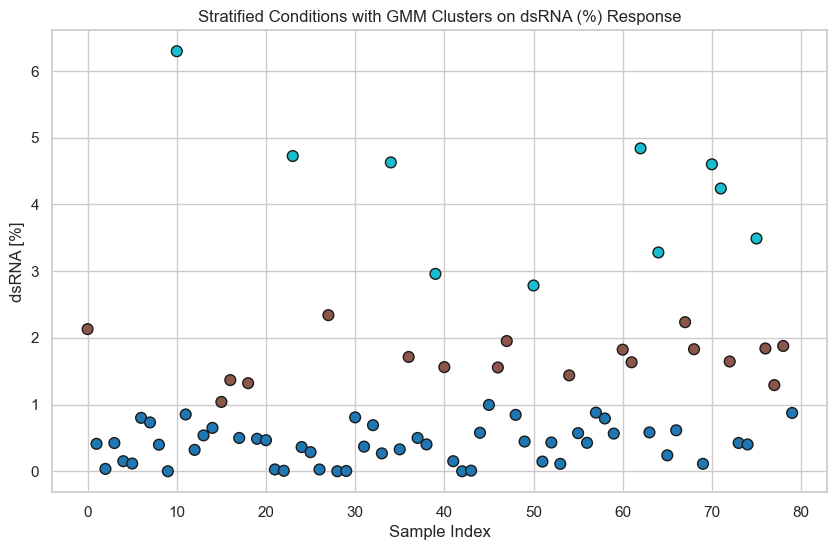

In [15]:
# Create stratified_conditions with GMM cluster labels
stratified_conditions = experimental_conditions.copy()
stratified_conditions["GMM_Cluster"] = gmm_labels

# Plot stratified_conditions for the dsRNA percentage response colored by GMM cluster label against sample index
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    np.arange(len(y_train)),
    y_train,
    c=stratified_conditions["GMM_Cluster"],
    cmap="tab10",
    s=60,
    edgecolor="k",
)
plt.xlabel("Sample Index")
plt.ylabel(y_columns[0])
plt.title("Stratified Conditions with GMM Clusters on dsRNA (%) Response")

In [16]:
stratified_conditions

,NTPs [M],T7RNAP [units/uL],DNA [µg/mL],Mg2+ [M],Reaction Time [min],GMM_Cluster
0,0.002237,109.285882,49.217245,0.013340,15.975448,1
1,0.011370,102.000948,92.963862,0.045625,205.895482,0
2,0.013120,301.864929,91.286401,0.034906,89.767563,0
3,0.012105,277.820595,61.743404,0.026270,44.601100,0
4,0.012105,277.820595,61.743404,0.026270,44.601100,0
...,...,...,...,...,...,...
75,0.014942,359.010522,54.952946,0.054598,143.752553,2
76,0.002423,148.507894,81.381476,0.009032,188.421396,1
77,0.008220,337.662327,74.517838,0.028639,73.872966,1
78,0.011866,287.674023,69.082018,0.067321,92.660776,1


Training set size: 40
Testing set size: 40


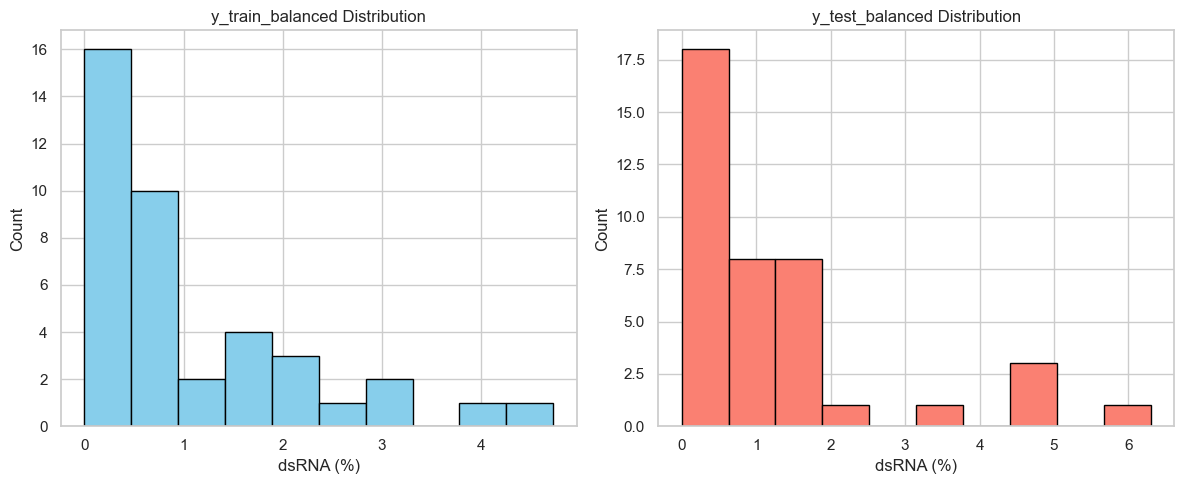

In [17]:
from sklearn.model_selection import train_test_split

# Use all data from stratified_conditions
all_indices = np.arange(len(stratified_conditions))
all_labels = stratified_conditions["GMM_Cluster"].values

# Stratified split by GMM cluster label
train_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.5,
    stratify=all_labels,
    random_state=41,
)

X_train_balanced = stratified_conditions.iloc[train_idx][features]
y_train_balanced = responses.iloc[train_idx][y_columns[0]]
X_test_balanced = stratified_conditions.iloc[test_idx][features]
y_test_balanced = responses.iloc[test_idx][y_columns[0]]

print(f"Training set size: {X_train_balanced.shape[0]}")
print(f"Testing set size: {X_test_balanced.shape[0]}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train_balanced, bins=10, color="skyblue", edgecolor="black")
plt.title("y_train_balanced Distribution")
plt.xlabel("dsRNA (%)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(y_test_balanced, bins=10, color="salmon", edgecolor="black")
plt.title("y_test_balanced Distribution")
plt.xlabel("dsRNA (%)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

R2 score on training set: 0.939
R2 score on testing set: -0.238


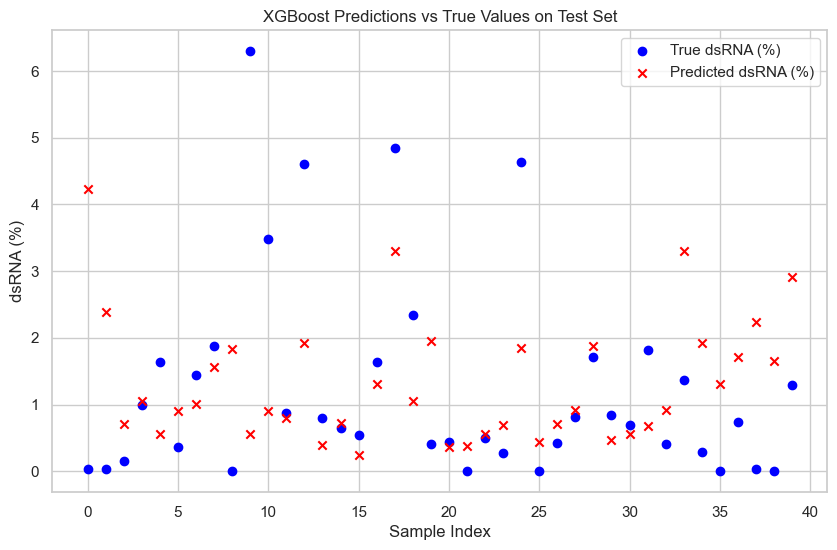

In [18]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Train XGBoost regressor
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_balanced.values, y_train_balanced)

# Predict on training and testing sets
y_train_pred = xgb.predict(X_train_balanced.values)
y_test_pred = xgb.predict(X_test_balanced.values)

# Calculate R2 scores
r2_train = r2_score(y_train_balanced, y_train_pred)
r2_test = r2_score(y_test_balanced, y_test_pred)

print(f"R2 score on training set: {r2_train:.3f}")
print(f"R2 score on testing set: {r2_test:.3f}")

# show the predictions of xgboost on the test set overlaided with the true values
plt.figure(figsize=(10, 6))
plt.scatter(
    np.arange(len(y_test_balanced)),
    y_test_balanced,
    label="True dsRNA (%)",
    color="blue",
    marker="o",
)
plt.scatter(
    np.arange(len(y_test_balanced)),
    y_test_pred,
    label="Predicted dsRNA (%)",
    color="red",
    marker="x",
)
plt.xlabel("Sample Index")
plt.ylabel("dsRNA (%)")
plt.title("XGBoost Predictions vs True Values on Test Set")
plt.legend()
plt.show()

R2 score on training set: 0.939
R2 score on testing set: -0.285
Root Mean Squared Error on test set: 1.702


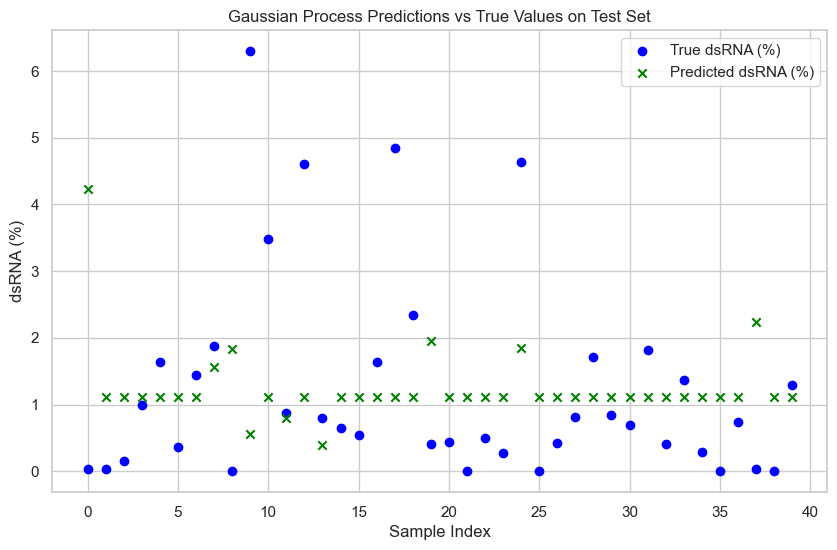

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Scale features and response for balanced train/test sets
scaler_x_bal = StandardScaler()
scaler_y_bal = StandardScaler()
X_train_bal_scaled = scaler_x_bal.fit_transform(X_train_balanced)
X_test_bal_scaled = scaler_x_bal.transform(X_test_balanced)
y_train_bal_scaled = scaler_y_bal.fit_transform(
    y_train_balanced.values.reshape(-1, 1)
).flatten()

# Fit Gaussian Process model
gp_model_bal = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2))
    * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5),
    n_restarts_optimizer=100,
    random_state=42,
)
gp_model_bal.fit(X_train_bal_scaled, y_train_bal_scaled)

# Predict on train and test sets
y_train_gp_scaled_pred = gp_model_bal.predict(X_train_bal_scaled)
y_test_gp_scaled_pred = gp_model_bal.predict(X_test_bal_scaled)
y_train_gp_pred = scaler_y_bal.inverse_transform(
    y_train_gp_scaled_pred.reshape(-1, 1)
).flatten()
y_test_gp_pred = scaler_y_bal.inverse_transform(
    y_test_gp_scaled_pred.reshape(-1, 1)
).flatten()

# Metrics
r2_train_gp = r2_score(y_train_balanced, y_train_gp_pred)
r2_test_gp = r2_score(y_test_balanced, y_test_gp_pred)
rmse_gp = np.sqrt(mean_squared_error(y_test_balanced, y_test_gp_pred))

print(f"R2 score on training set: {r2_train_gp:.3f}")
print(f"R2 score on testing set: {r2_test_gp:.3f}")
print(f"Root Mean Squared Error on test set: {rmse_gp:.3f}")

# Plot predictions vs true values for test set
plt.figure(figsize=(10, 6))
plt.scatter(
    np.arange(len(y_test_balanced)),
    y_test_balanced,
    label="True dsRNA (%)",
    color="blue",
    marker="o",
)
plt.scatter(
    np.arange(len(y_test_balanced)),
    y_test_gp_pred,
    label="Predicted dsRNA (%)",
    color="green",
    marker="x",
)
plt.xlabel("Sample Index")
plt.ylabel("dsRNA (%)")
plt.title("Gaussian Process Predictions vs True Values on Test Set")
plt.legend()
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  dsRNA   No. Observations:                   40
Model:                            GLM   Df Residuals:                       34
Model Family:                 Tweedie   Df Model:                            5
Link Function:                    log   Scale:                          1.0090
Method:                          IRLS   Log-Likelihood:                -49.839
Date:                Thu, 09 Oct 2025   Deviance:                       35.291
Time:                        20:25:20   Pearson chi2:                     34.3
No. Iterations:                    14   Pseudo R-squ. (CS):             0.1197
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1927      0.759      1.572      0.1

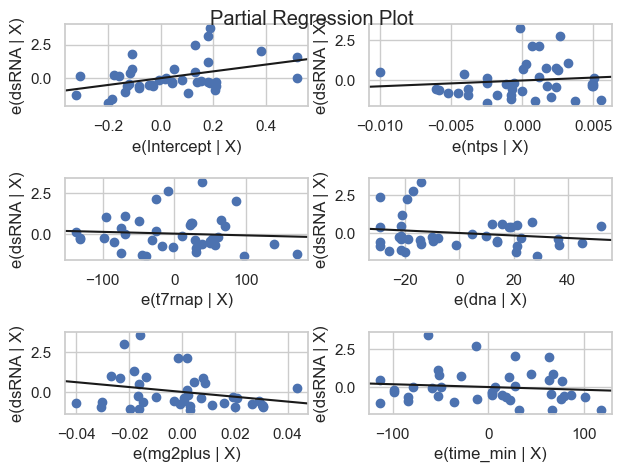

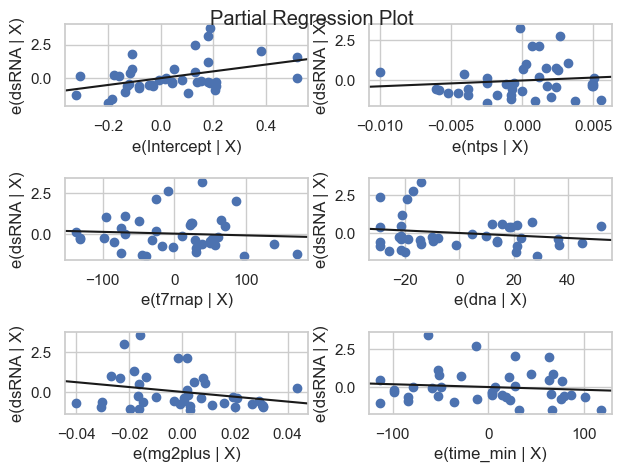

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


def transform_column_to_formula_var(colname: str) -> str:
    if "time" in colname or "Time" in colname or "TIME" in colname:
        return "time_min"
    colname = colname.replace("+", "plus").replace("-", "minus")
    return colname.split(" ")[0].lower()


# --- Build modelling frame ---
df = experimental_conditions.copy()
df["dsRNA"] = responses.values.ravel()
df = df.rename(
    columns={
        col: transform_column_to_formula_var(col)
        for col in experimental_conditions.columns
    }
)

y_col = "dsRNA"
# Prepare train data for GLM
glm_train_data = X_train_balanced.copy()
glm_train_data["dsRNA"] = y_train_balanced.values
glm_train_data = glm_train_data.rename(
    columns={
        col: transform_column_to_formula_var(col) for col in X_train_balanced.columns
    }
)

# Build formula with all main effects using transformed feature names
transformed_features = [
    transform_column_to_formula_var(col) for col in X_train_balanced.columns
]
formula = "dsRNA ~ " + " + ".join(transformed_features)

# Fit GLM with Tweedie family (power=1.5 is common for continuous positive data)
tweedie_family = sm.families.Tweedie(var_power=1.5, link=sm.families.links.log())
glm_model = smf.glm(formula, data=glm_train_data, family=tweedie_family)
glm_res = glm_model.fit()
print(glm_res.summary())

# Model diagnostics
sm.graphics.plot_partregress_grid(glm_res)

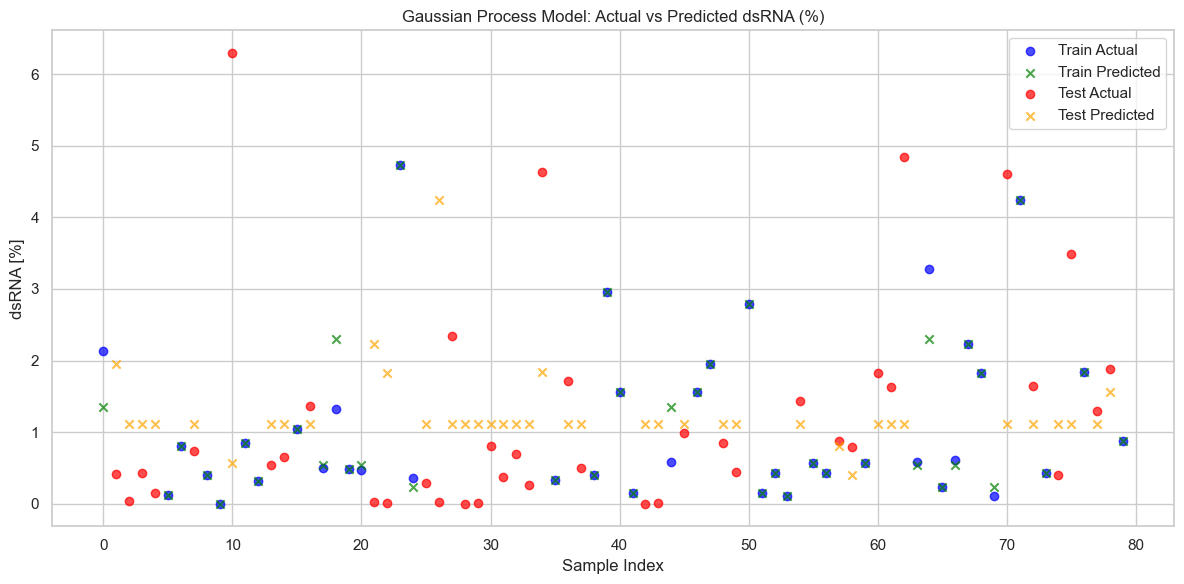

In [21]:
plt.figure(figsize=(12, 6))
# Training set
plt.scatter(
    train_idx,
    y_train_balanced,
    color="blue",
    marker="o",
    label="Train Actual",
    alpha=0.7,
)
plt.scatter(
    train_idx,
    y_train_gp_pred,
    color="green",
    marker="x",
    label="Train Predicted",
    alpha=0.7,
)
# Test set
plt.scatter(
    test_idx,
    y_test_balanced,
    color="red",
    marker="o",
    label="Test Actual",
    alpha=0.7,
)
plt.scatter(
    test_idx,
    y_test_gp_pred,
    color="orange",
    marker="x",
    label="Test Predicted",
    alpha=0.7,
)
plt.xlabel("Sample Index")
plt.ylabel(y_columns[0])
plt.title("Gaussian Process Model: Actual vs Predicted dsRNA (%)")
plt.legend()
plt.tight_layout()
plt.show()

R2 score on training set (nonzero): 0.938
R2 score on testing set (nonzero): -1.726
Root Mean Squared Error on test set (nonzero): 2.498


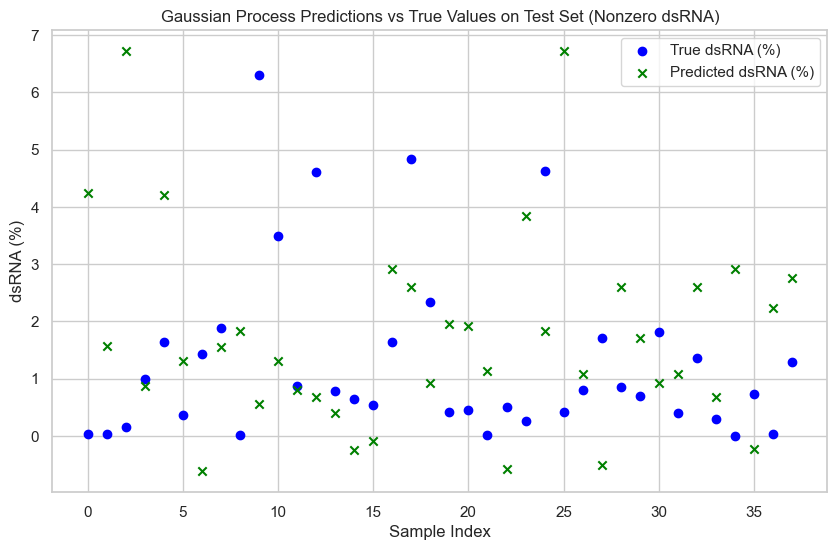

In [22]:
# Remove samples with zero dsRNA percentage from train and test sets
nonzero_train_mask = y_train_balanced != 0
nonzero_test_mask = y_test_balanced != 0

X_train_balanced_nz = X_train_balanced[nonzero_train_mask]
y_train_balanced_nz = y_train_balanced[nonzero_train_mask]
X_test_balanced_nz = X_test_balanced[nonzero_test_mask]
y_test_balanced_nz = y_test_balanced[nonzero_test_mask]

# Scale features and response for balanced train/test sets (nonzero only)
scaler_x_bal_nz = StandardScaler()
scaler_y_bal_nz = StandardScaler()
X_train_bal_scaled_nz = scaler_x_bal_nz.fit_transform(X_train_balanced_nz)
X_test_bal_scaled_nz = scaler_x_bal_nz.transform(X_test_balanced_nz)
y_train_bal_scaled_nz = scaler_y_bal_nz.fit_transform(
    y_train_balanced_nz.values.reshape(-1, 1)
).flatten()

# Fit Gaussian Process model
gp_model_bal_nz = GaussianProcessRegressor(
    kernel=C(1.0, (1e-2, 1e2))
    * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5),
    n_restarts_optimizer=100,
    random_state=42,
)
gp_model_bal_nz.fit(X_train_bal_scaled_nz, y_train_bal_scaled_nz)

# Predict on train and test sets
y_train_gp_scaled_pred_nz = gp_model_bal_nz.predict(X_train_bal_scaled_nz)
y_test_gp_scaled_pred_nz = gp_model_bal_nz.predict(X_test_bal_scaled_nz)
y_train_gp_pred_nz = scaler_y_bal_nz.inverse_transform(
    y_train_gp_scaled_pred_nz.reshape(-1, 1)
).flatten()
y_test_gp_pred_nz = scaler_y_bal_nz.inverse_transform(
    y_test_gp_scaled_pred_nz.reshape(-1, 1)
).flatten()

# Metrics
r2_train_gp_nz = r2_score(y_train_balanced_nz, y_train_gp_pred_nz)
r2_test_gp_nz = r2_score(y_test_balanced_nz, y_test_gp_pred_nz)
rmse_gp_nz = np.sqrt(mean_squared_error(y_test_balanced_nz, y_test_gp_pred_nz))

print(f"R2 score on training set (nonzero): {r2_train_gp_nz:.3f}")
print(f"R2 score on testing set (nonzero): {r2_test_gp_nz:.3f}")
print(f"Root Mean Squared Error on test set (nonzero): {rmse_gp_nz:.3f}")

# Plot predictions vs true values for test set (nonzero only)
plt.figure(figsize=(10, 6))
plt.scatter(
    np.arange(len(y_test_balanced_nz)),
    y_test_balanced_nz,
    label="True dsRNA (%)",
    color="blue",
    marker="o",
)
plt.scatter(
    np.arange(len(y_test_balanced_nz)),
    y_test_gp_pred_nz,
    label="Predicted dsRNA (%)",
    color="green",
    marker="x",
)
plt.xlabel("Sample Index")
plt.ylabel("dsRNA (%)")
plt.title("Gaussian Process Predictions vs True Values on Test Set (Nonzero dsRNA)")
plt.legend()
plt.show()

# Empirical Risk Minimization (ERM)

If we penalize more heavily for wrongly predicting low levels of dsRNA percentage, we
could get a better model.


# Ensemble Methods

- we could build a discrepancy model however there are no guarantees that it will
  generalised out of sample.
- we could also build a model for each cluster and ensemble them together using
  either a rule based approach or a meta model or a weighted average.


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

cluster_metrics = {}

for cluster in np.unique(stratified_conditions["GMM_Cluster"]):
    train_mask = stratified_conditions.iloc[train_idx]["GMM_Cluster"] == cluster
    test_mask = stratified_conditions.iloc[test_idx]["GMM_Cluster"] == cluster

    X_train_c = X_train_balanced[train_mask]
    y_train_c = y_train_balanced[train_mask]
    X_test_c = X_test_balanced[test_mask]
    y_test_c = y_test_balanced[test_mask]

    if len(X_train_c) == 0 or len(X_test_c) == 0:
        continue

    # Gaussian Process
    scaler_x_c = StandardScaler()
    scaler_y_c = StandardScaler()
    X_train_c_scaled = scaler_x_c.fit_transform(X_train_c)
    X_test_c_scaled = scaler_x_c.transform(X_test_c)
    y_train_c_scaled = scaler_y_c.fit_transform(
        y_train_c.values.reshape(-1, 1)
    ).flatten()
    gp_c = GaussianProcessRegressor(
        kernel=C(1.0, (1e-2, 1e2))
        * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5),
        n_restarts_optimizer=100,
        random_state=42,
    )
    gp_c.fit(X_train_c_scaled, y_train_c_scaled)
    y_train_pred_gp = scaler_y_c.inverse_transform(
        gp_c.predict(X_train_c_scaled).reshape(-1, 1)
    ).flatten()
    y_test_pred_gp = scaler_y_c.inverse_transform(
        gp_c.predict(X_test_c_scaled).reshape(-1, 1)
    ).flatten()

    # Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train_c, y_train_c)
    y_train_pred_rf = rf.predict(X_train_c)
    y_test_pred_rf = rf.predict(X_test_c)

    # XGBoost
    xgb_c = XGBRegressor(random_state=42)
    xgb_c.fit(X_train_c.values, y_train_c)
    y_train_pred_xgb = xgb_c.predict(X_train_c.values)
    y_test_pred_xgb = xgb_c.predict(X_test_c.values)

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train_c, y_train_c)
    y_train_pred_lr = lr.predict(X_train_c)
    y_test_pred_lr = lr.predict(X_test_c)

    cluster_metrics[cluster] = {
        "GP_train": r2_score(y_train_c, y_train_pred_gp),
        "GP_test": r2_score(y_test_c, y_test_pred_gp),
        "RF_train": r2_score(y_train_c, y_train_pred_rf),
        "RF_test": r2_score(y_test_c, y_test_pred_rf),
        "XGB_train": r2_score(y_train_c, y_train_pred_xgb),
        "XGB_test": r2_score(y_test_c, y_test_pred_xgb),
        "LR_train": r2_score(y_train_c, y_train_pred_lr),
        "LR_test": r2_score(y_test_c, y_test_pred_lr),
    }

    print(
        f"Cluster {cluster}: "
        f"GP R2 train={cluster_metrics[cluster]['GP_train']:.3f}, test={cluster_metrics[cluster]['GP_test']:.3f} | "
        f"RF R2 train={cluster_metrics[cluster]['RF_train']:.3f}, test={cluster_metrics[cluster]['RF_test']:.3f} | "
        f"XGB R2 train={cluster_metrics[cluster]['XGB_train']:.3f}, test={cluster_metrics[cluster]['XGB_test']:.3f} | "
        f"LR R2 train={cluster_metrics[cluster]['LR_train']:.3f}, test={cluster_metrics[cluster]['LR_test']:.3f}"
    )

Cluster 0: GP R2 train=0.966, test=0.067 | RF R2 train=0.815, test=-0.059 | XGB R2 train=0.966, test=-0.015 | LR R2 train=0.216, test=0.099
Cluster 1: GP R2 train=1.000, test=-0.438 | RF R2 train=0.876, test=-1.198 | XGB R2 train=1.000, test=-1.194 | LR R2 train=0.759, test=-2.620
Cluster 2: GP R2 train=1.000, test=-1.792 | RF R2 train=0.736, test=-1.834 | XGB R2 train=1.000, test=-2.435 | LR R2 train=1.000, test=-130.774


# Causal Inference on the Clusters

We could use causal inference methods to identify potential causal relationships
between features and dsRNA percentage within each cluster.


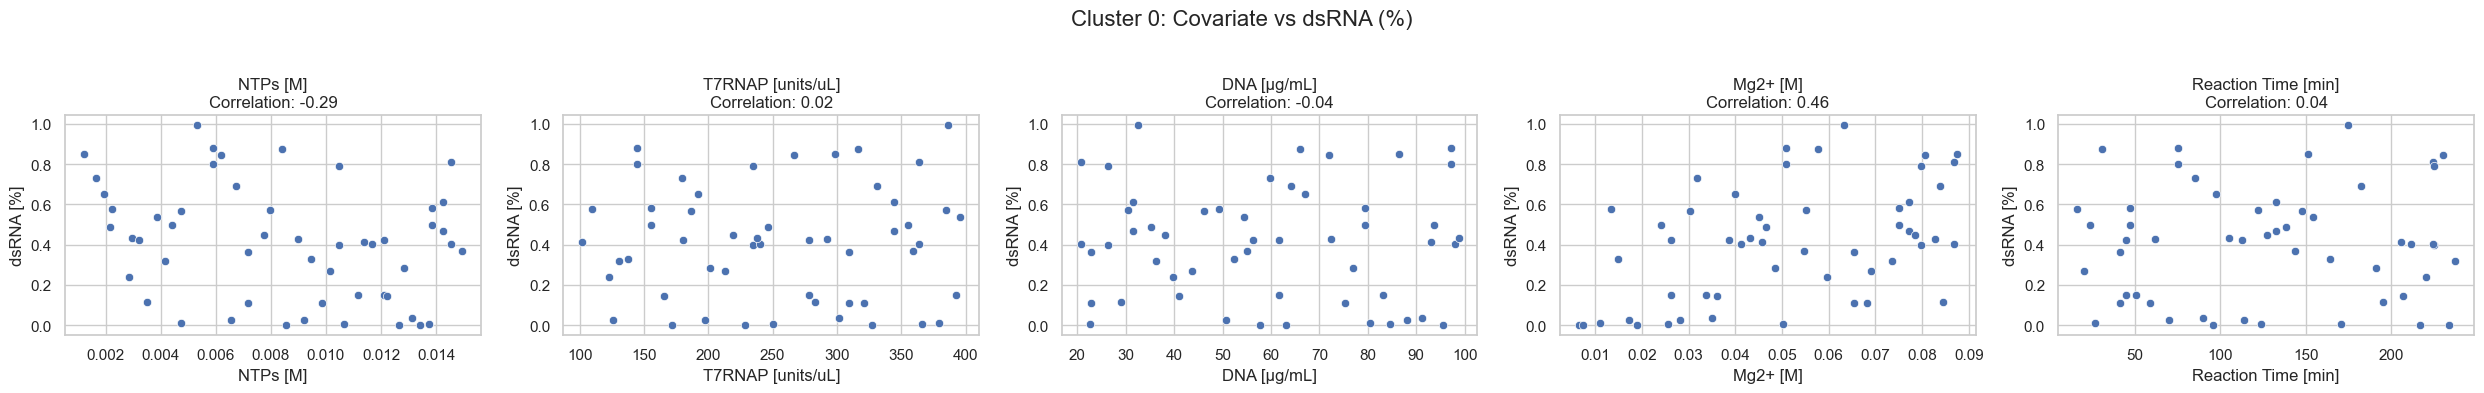

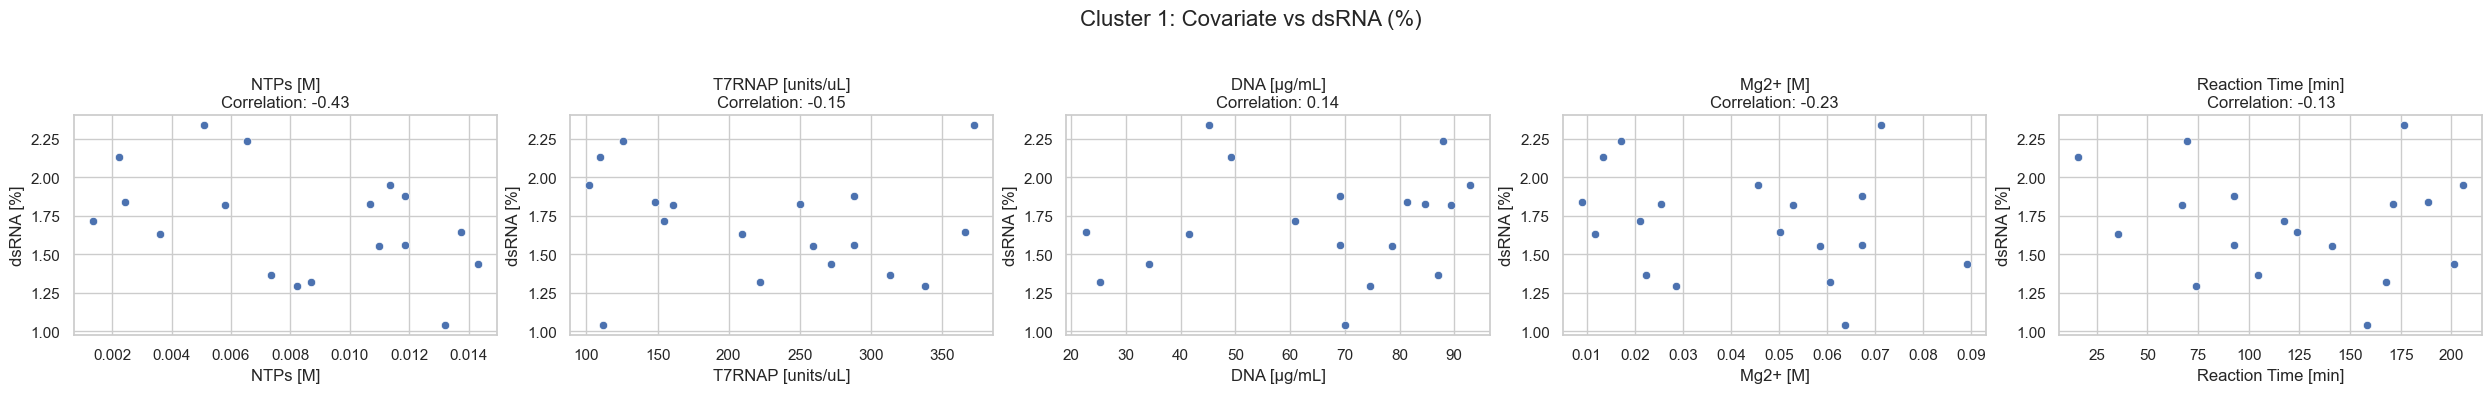

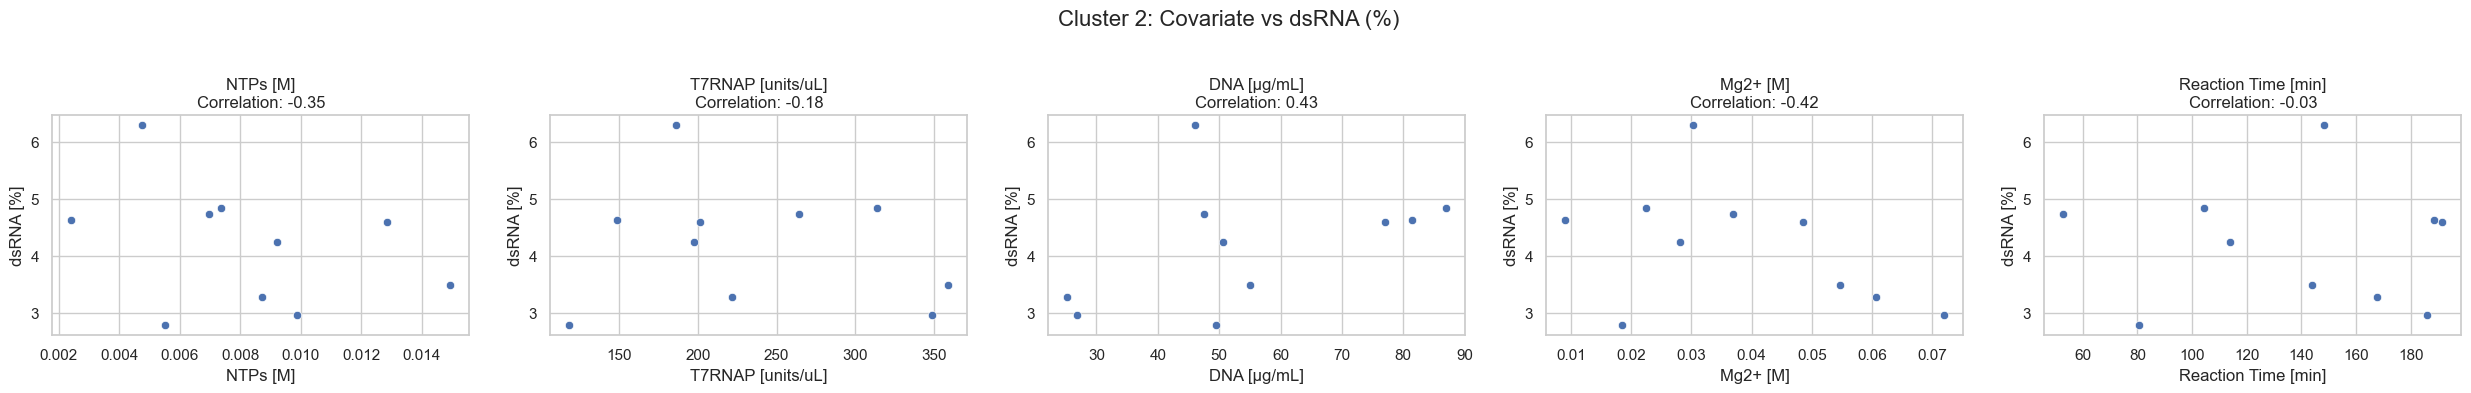

In [24]:
import seaborn as sns

# Correlation plots for each covariate within each cluster

for cluster in np.unique(stratified_conditions["GMM_Cluster"]):
    cluster_data = stratified_conditions[
        stratified_conditions["GMM_Cluster"] == cluster
    ]
    fig, axes = plt.subplots(1, len(features), figsize=(5 * len(features), 4))
    fig.suptitle(f"Cluster {cluster}: Covariate vs dsRNA (%)", fontsize=16)
    for j, feature in enumerate(features):
        sns.scatterplot(
            x=cluster_data[feature],
            y=responses.loc[cluster_data.index, y_columns[0]],
            ax=axes[j],
        )
        corr = cluster_data[feature].corr(
            responses.loc[cluster_data.index, y_columns[0]]
        )
        axes[j].set_title(f"{feature}\nCorrelation: {corr:.2f}")
        axes[j].set_xlabel(feature)
        axes[j].set_ylabel(y_columns[0])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

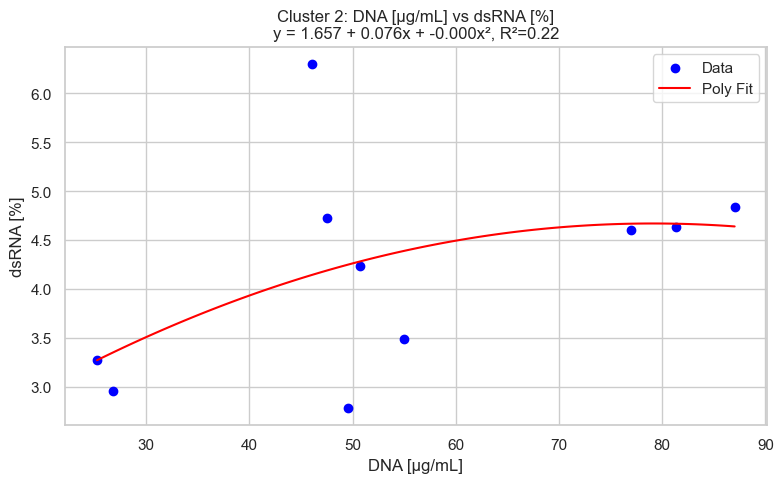

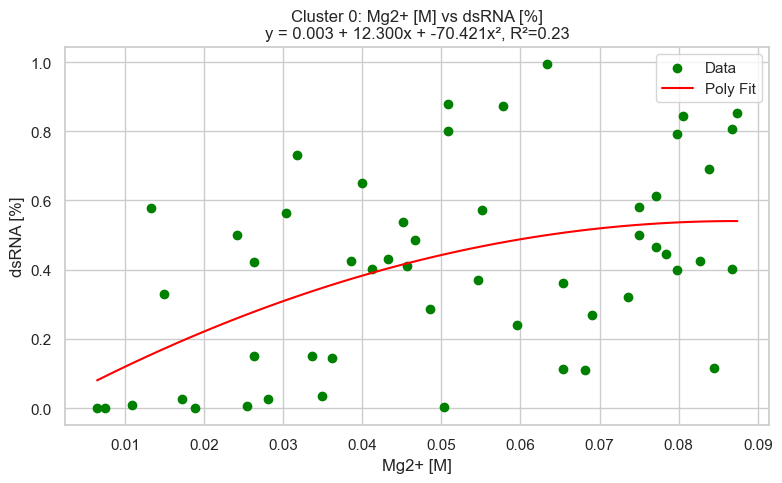

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

import matplotlib.pyplot as plt

# Cluster 2: DNA [µg/mL] vs dsRNA [%]
cluster2 = stratified_conditions[stratified_conditions["GMM_Cluster"] == 2]
X_dna = cluster2["DNA [µg/mL]"].values.reshape(-1, 1)
y_dna = responses.loc[cluster2.index, y_columns[0]].values

poly2 = PolynomialFeatures(degree=2)
X_dna_poly = poly2.fit_transform(X_dna)
model_dna = LinearRegression()
model_dna.fit(X_dna_poly, y_dna)
y_dna_pred = model_dna.predict(X_dna_poly)
r2_dna = r2_score(y_dna, y_dna_pred)

# Equation for DNA fit
coef_dna = model_dna.coef_
intercept_dna = model_dna.intercept_
eq_dna = f"y = {intercept_dna:.3f} + {coef_dna[1]:.3f}x + {coef_dna[2]:.3f}x²"

plt.figure(figsize=(8, 5))
plt.scatter(X_dna, y_dna, color="blue", label="Data")
x_plot = np.linspace(X_dna.min(), X_dna.max(), 100).reshape(-1, 1)
y_plot = model_dna.predict(poly2.transform(x_plot))
plt.plot(x_plot, y_plot, color="red", label="Poly Fit")
plt.title(f"Cluster 2: DNA [µg/mL] vs dsRNA [%]\n{eq_dna}, R²={r2_dna:.2f}")
plt.xlabel("DNA [µg/mL]")
plt.ylabel("dsRNA [%]")
plt.legend()
plt.tight_layout()
plt.show()

# Cluster 0: Mg2+ [M] vs dsRNA [%]
cluster0 = stratified_conditions[stratified_conditions["GMM_Cluster"] == 0]
X_mg = cluster0["Mg2+ [M]"].values.reshape(-1, 1)
y_mg = responses.loc[cluster0.index, y_columns[0]].values

poly2_mg = PolynomialFeatures(degree=2)
X_mg_poly = poly2_mg.fit_transform(X_mg)
model_mg = LinearRegression()
model_mg.fit(X_mg_poly, y_mg)
y_mg_pred = model_mg.predict(X_mg_poly)
r2_mg = r2_score(y_mg, y_mg_pred)

# Equation for Mg2+ fit
coef_mg = model_mg.coef_
intercept_mg = model_mg.intercept_
eq_mg = f"y = {intercept_mg:.3f} + {coef_mg[1]:.3f}x + {coef_mg[2]:.3f}x²"

plt.figure(figsize=(8, 5))
plt.scatter(X_mg, y_mg, color="green", label="Data")
x_plot_mg = np.linspace(X_mg.min(), X_mg.max(), 100).reshape(-1, 1)
y_plot_mg = model_mg.predict(poly2_mg.transform(x_plot_mg))
plt.plot(x_plot_mg, y_plot_mg, color="red", label="Poly Fit")
plt.title(f"Cluster 0: Mg2+ [M] vs dsRNA [%]\n{eq_mg}, R²={r2_mg:.2f}")
plt.xlabel("Mg2+ [M]")
plt.ylabel("dsRNA [%]")
plt.legend()
plt.tight_layout()
plt.show()

# Classification of No dsRNA vs dsRNA

We could also try to classify samples into two categories: those with no dsRNA and
those with dsRNA. This could be a simpler task than predicting the exact percentage
of dsRNA and could still provide useful information for process optimization.

we can then also do feature importance analysis.


Class distribution:
dsRNA [%]
0    52
1    28
Name: count, dtype: int64
Train set size: 28
Test set size: 28
Classification accuracy on test set: 0.429


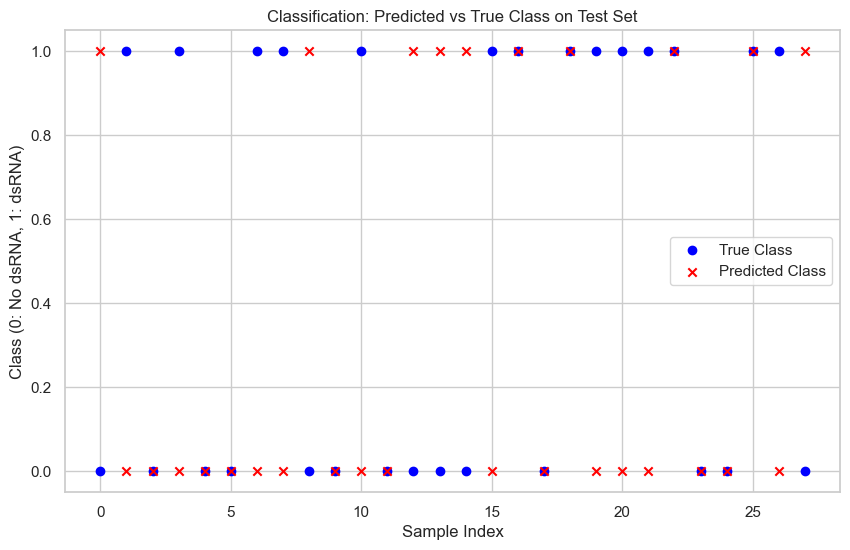

In [39]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Create binary classification target: 0 if dsRNA == 0, 1 if dsRNA > 0
y_class = (responses[y_columns[0]] >= 1).astype(int)

print(f"Class distribution:\n{y_class.value_counts()}")

# Features
X_class = experimental_conditions[X_columns]

# Find indices for each class
idx_0 = np.where(y_class == 0)[0]
idx_1 = np.where(y_class == 1)[0]

# Find minimum count for balanced split
min_count = min(len(idx_0), len(idx_1))

# Randomly select min_count samples from each class for train and test
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression

# xboost classifier
from xgboost import XGBClassifier

# catboost classifier
from catboost import CatBoostClassifier

idx_0 = shuffle(idx_0, random_state=42)
idx_1 = shuffle(idx_1, random_state=42)

# Split half for train, half for test
split = min_count // 2

train_idx = np.concatenate([idx_0[:split], idx_1[:split]])
test_idx = np.concatenate([idx_0[split:min_count], idx_1[split:min_count]])

# Shuffle indices for randomness
train_idx = shuffle(train_idx, random_state=42)
test_idx = shuffle(test_idx, random_state=42)

X_train_cls = X_class.iloc[train_idx]
y_train_cls = y_class.iloc[train_idx]
X_test_cls = X_class.iloc[test_idx]
y_test_cls = y_class.iloc[test_idx]

print(f"Train set size: {len(y_train_cls)}")
print(f"Test set size: {len(y_test_cls)}")

# clf = CatBoostClassifier(
#     iterations=10_000,
#     learning_rate=0.05,
#     depth=6,
#     eval_metric="Accuracy",
#     random_seed=42,
#     verbose=100,
# )
# clf.fit(X_train_cls.values, y_train_cls)
# clf = XGBClassifier(random_state=42)
# clf.fit(X_train_cls.values, y_train_cls)
# clf = HistGradientBoostingClassifier(random_state=42)
# clf.fit(X_train_cls.values, y_train_cls)
# clf = LogisticRegression(max_iter=1000, random_state=42)
# clf.fit(X_train_cls.values, y_train_cls)
clf = SVC(probability=True, random_state=42)
clf.fit(X_train_cls.values, y_train_cls)

# Predict and show accuracy
y_pred_cls = clf.predict(X_test_cls)
acc = accuracy_score(y_test_cls, y_pred_cls)
print(f"Classification accuracy on test set: {acc:.3f}")


# show the predictions overlaid with the true values
plt.figure(figsize=(10, 6))
plt.scatter(
    np.arange(len(y_test_cls)),
    y_test_cls,
    label="True Class",
    color="blue",
    marker="o",
)
plt.scatter(
    np.arange(len(y_test_cls)),
    y_pred_cls,
    label="Predicted Class",
    color="red",
    marker="x",
)
plt.xlabel("Sample Index")
plt.ylabel("Class (0: No dsRNA, 1: dsRNA)")
plt.title("Classification: Predicted vs True Class on Test Set")
plt.legend()
plt.show()